In [81]:
import json
from attrdict import AttrDict
from collections import defaultdict
import networkx as nx


def load(name):
    """Loads a file"""
    with open('bmeg-etl/source/tcia/{}.json'.format(name), 'r') as ins:
        for line in ins:
            yield AttrDict(json.loads(line))


def load_all():
    """Returns a tuple of object arrays"""
    all_patients = [o for o in load('patients')]
    all_patient_study = [o for o in load('patient_study')]
    all_series = [o for o in load('series')]
    return (all_patients, all_patient_study, all_series)



class TCIATransformer():

    def __init__(self):
        # fetch data
        (self.all_patients, self.all_patient_study, self.all_series) = load_all()
        for a in (self.all_patients, self.all_patient_study, self.all_series):
            print(len(a))

    def graph(self):
        """Creates graph"""
        G = nx.MultiDiGraph()
        G.add_nodes_from(set([case.Collection for case in self.all_patients]), label='Project')
        G.add_nodes_from(set([case.PatientID for case in self.all_patients]), label='Case')
        G.add_edges_from([(case.Collection, case.PatientID) for case in self.all_patients], label='cases')

        # add ['PatientName', 'PatientSex']
        G.add_nodes_from(set([case.PatientID + '-demographic' for case in self.all_patients]), label='Demographic')
        G.add_edges_from([(case.PatientID, case.PatientID + '-demographic' ) for case in self.all_patients], label='demographics')

        G.add_nodes_from(set([study.StudyInstanceUID for study in self.all_patient_study]), label='Study')
        G.add_edges_from([(study.PatientID, study.StudyInstanceUID ) for study in self.all_patient_study], label='studies')

        # note the api seems to be returning one series that is really a study   
        series = list(filter(lambda s: s.SeriesInstanceUID != '1.3.6.1.4.1.14519.5.2.1.6279.6001.287560874054243719452635194040', tcia_transformer.all_series))        
        G.add_nodes_from(set([s.SeriesInstanceUID for s in series]), label='Series')
        G.add_edges_from([(s.StudyInstanceUID, s.SeriesInstanceUID ) for s in series], label='series')
        
        return G


In [2]:
from bmeg_etl.transformer.tcia.tcia_transformer import TCIATransformer


tcia_transformer = TCIATransformer()
G = tcia_transformer.graph()
assert len(G.nodes) == 188666, 'Should have lots of nodes {}'.format(len(G.nodes))

node_counts = defaultdict(int)
for k, v in list(G.nodes.data()):
    node_counts[v['label']] += 1
actual = sorted(node_counts.items())
print(actual)



ModuleNotFoundError: No module named 'bmeg_etl.transformer'

In [5]:
from bmeg_etl.transform.tcia.tcia_transformer import TCIATransformer
#import bmeg_etl.transform.tcia.tcia_transformer
dir(bmeg_etl)

ModuleNotFoundError: No module named 'transform'

In [4]:
import sys
print(sys.path)

['/home/jovyan/work', '/opt/conda/lib/python37.zip', '/opt/conda/lib/python3.7', '/opt/conda/lib/python3.7/lib-dynload', '', '/opt/conda/lib/python3.7/site-packages', '/home/jovyan/client-apis/pyAnVIL', '/opt/conda/lib/python3.7/site-packages/IPython/extensions', '/home/jovyan/.ipython']


In [29]:
tcia_transformer.all_patients[0]

AttrDict({'PatientID': 'TCGA-08-0244', 'PatientName': '', 'PatientSex': 'M', 'Collection': 'TCGA-GBM'})

In [26]:
tcia_transformer.all_patient_study[0]

AttrDict({'Collection': 'TCGA-GBM', 'PatientID': 'TCGA-06-0119', 'PatientName': 'TCGA-06-0119', 'PatientSex': 'F', 'StudyInstanceUID': '1.3.6.1.4.1.14519.5.2.1.4591.4001.283171458436570880779969690543', 'StudyDate': '2003-12-26', 'SeriesCount': 16})

In [27]:
tcia_transformer.all_series[0]

AttrDict({'SeriesInstanceUID': '1.3.6.1.4.1.14519.5.2.1.7695.4001.306204232344341694648035234440', 'StudyInstanceUID': '1.3.6.1.4.1.14519.5.2.1.7695.4001.130563880911723253267280582465', 'Modality': 'MR', 'SeriesDate': '1998-12-08', 'SeriesDescription': '3DSPGR AXIAL', 'BodyPartExamined': 'BRAIN', 'SeriesNumber': '2.000000', 'Collection': 'TCGA-GBM', 'Manufacturer': 'GE MEDICAL SYSTEMS', 'ManufacturerModelName': 'GENESIS_SIGNA', 'SoftwareVersions': '07', 'Visibility': '1', 'ImageCount': 124})

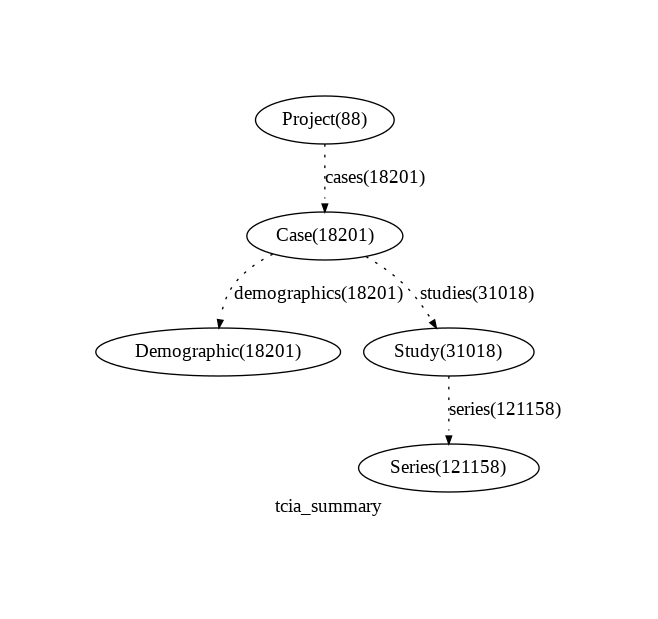

In [84]:
from graph_summarizer import summarize_graph, draw_summary
draw_summary(summarize_graph(G), 'tcia_summary')

In [42]:
patients[0].keys()

dict_keys(['PatientID', 'PatientName', 'PatientSex', 'Collection'])

In [53]:
with tcia_client.get_collection_values(collections[0]) as response:
    if response.status == 200:
        data = response.read().decode('utf-8')
        collection_data = json.loads(data)   

In [54]:
(len(collection_data),collection_data[0])

(89, {'Collection': 'TCGA-GBM'})

In [55]:
with tcia_client.get_manufacturer_values(collections[0]) as response:
    if response.status == 200:
        data = response.read().decode('utf-8')
        manufacturer_values = json.loads(data)   

In [56]:
(len(manufacturer_values),manufacturer_values[0])

(3, {'Manufacturer': 'GE MEDICAL SYSTEMS'})

In [57]:
manufacturer_values

[{'Manufacturer': 'GE MEDICAL SYSTEMS'},
 {'Manufacturer': 'SIEMENS'},
 {'Manufacturer': 'Philips'}]

In [53]:
import requests
import json
from attrdict import AttrDict

# see swagger docs
# https://clinicalapi-cptac.esacinc.com/api/tcia/
    
base = 'https://clinicalapi-cptac.esacinc.com/api/tcia'

tcia_config = AttrDict({
    'programs': '{base}/programs/summary',
    'studies': '{base}/studies/summary',
    'clinical_data': '{base}/clinical_data/tumor_code/{tumor_code}',
    'slides': '{base}/case/{case_id}/slides',    
})

# "https://clinicalapi-cptac.esacinc.com/api/tcia/programs"
# requests.get("https://clinicalapi-cptac.esacinc.com/api/tcia/programs/summary").json()

programs = requests.get(tcia_config.programs.format(base=base)).json()
with open('outputs/tcia/programs.json' , 'w') as outs:
    for p in programs:
        json.dump(p, outs)
        outs.write('\n')


studies = requests.get(tcia_config.studies.format(base=base)).json()
with open('outputs/tcia/studies.json' , 'w') as outs:
    for s in studies:
        json.dump(s, outs)
        outs.write('\n')
        

tcga_tumor_codes = set([s['TCGA_Tumor_Code'] for s in studies + programs])
cptac_tumor_codes = set([s['CPTAC_Tumor_Code'] for s in studies + programs])

tumor_codes = set(tcga_tumor_codes.union(cptac_tumor_codes))


In [56]:
case_ids = set()
with open('outputs/tcia/clinical_data.json' , 'w') as outs:
    for tumor_code in tumor_codes:
        rsp = requests.get(tcia_config.clinical_data.format(base=base, tumor_code=tumor_code))
        clinical_data = rsp.json()
        if rsp.status_code != 200:
            print('tumor_code {} status {}'.format(tumor_code, rsp.status_code))
            continue
        json.dump(clinical_data, outs)
        outs.write('\n')
        case_ids.update([cd['case_id'] for cd in clinical_data])
print(len(case_ids))        

tumor_code LAML status 400
tumor_code KIRC status 400
tumor_code PAAD status 400
tumor_code SKCM status 400
tumor_code LUSC status 400
1390


In [37]:
slide_ids = set()
with open('outputs/tcia/slides.json' , 'w') as outs:
    for case_id in case_ids:
        url = tcia_config.slides.format(base=base, case_id=case_id)
        case_slide_ids = requests.get(url).json()
        slide_ids.update(case_slide_ids)
print(len(slide_ids)) 

5039


In [40]:
import json
from tciaclient import TCIAClient
api_key='76a553ad-1208-40db-b2ee-20e0edead0c8'
tcia_client = TCIAClient(apiKey = api_key,baseUrl="https://services.cancerimagingarchive.net/services/v3",resource = "TCIA")

patients = []
with tcia_client.get_patient() as response:
    if response.status == 200:
        data = response.read().decode('utf-8')
        patients = json.loads(data)   

print(len(patients))        
        

18201


In [47]:
patient_ids = set([p['PatientID']for p in patients])

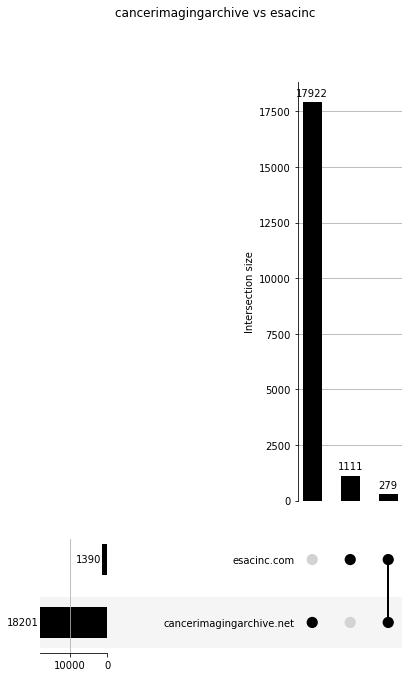

In [57]:
#patient_ids.intersection(case_ids)

import matplotlib.pyplot
import pandas
import upsetplot



project_df =  pandas.DataFrame(upsetplot.from_contents(
    {
        'esacinc.com': case_ids,
        'cancerimagingarchive.net': patient_ids
    }    
))


upsetplot.plot(project_df, sort_by="cardinality", sum_over=False, show_counts='%d' ) # 
current_figure = matplotlib.pyplot.gcf()
current_figure.suptitle('cancerimagingarchive vs esacinc')
current_figure.set_size_inches(6.5, 10.5)
current_figure.savefig("participant_project.png")

In [61]:
# patient_ids created from cancerimaging, case_ids created from esac
list(sorted(patient_ids.intersection(case_ids)))[:10]

['C3L-00016',
 'C3L-00017',
 'C3L-00019',
 'C3L-00189',
 'C3L-00263',
 'C3L-00265',
 'C3L-00275',
 'C3L-00277',
 'C3L-00278',
 'C3L-00279']

In [67]:
list(patient_ids - case_ids)[:10]

['Mass-Training_P_01039_RIGHT_MLO_5',
 '520664924',
 'Calc-Training_P_00750_RIGHT_CC_1',
 '1.3.6.1.4.1.9328.50.4.0005',
 '1.3.6.1.4.1.9328.50.4.0122',
 'UCSF-BR-14',
 '1.3.6.1.4.1.9328.50.4.0194',
 'LIDC-IDRI-0055',
 'ISPY1_1010',
 'Mass-Training_P_01241_RIGHT_MLO']

In [68]:
list(case_ids - patient_ids)[:10]

['C3N-04273',
 'C3N-02763',
 'C3N-02237',
 'C3N-02264',
 'C3N-01082',
 'C3N-01818',
 'C3N-03781',
 'C3L-01631',
 'C3L-00789',
 'C3N-00436']